In [24]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from glob import glob
import cv2
from tqdm.notebook import tqdm

from fastai.vision.all import *
from fastai.vision import models
import torch

import sys
sys.path.append('../')
from src.types.tensor_tiles import BrightfieldTile, FluorescenceTile
from src.stats_reader import DataStats
from src.transforms.augmentations import PairAugmentations
from src.transforms.pair_transform import PairTransform
from src.losses import VGGTrainedPerceptualLoss

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
bs = 2
zoom = 60
stats_path = '../configs/data_statistics.json'
STATS = DataStats(stats_path, zoom)

path = '../input/preview_tile_set/'
df = pd.read_csv(os.path.join(path, f'train_{zoom}.csv'))
df.head()

,fn,fold,slide_name,start_x,start_y,tile_sz,slide_width,slide_height,target_fn
0,input_60_128/AssayPlate_Greiner_#655090_D04__0__0.npy,3,AssayPlate_Greiner_#655090_D04,0,0,128,2556,2156,target_60_128/AssayPlate_Greiner_#655090_D04__0__0.npy
1,input_60_128/AssayPlate_Greiner_#655090_D04__0__115.npy,2,AssayPlate_Greiner_#655090_D04,0,115,128,2556,2156,target_60_128/AssayPlate_Greiner_#655090_D04__0__115.npy
2,input_60_128/AssayPlate_Greiner_#655090_D04__0__230.npy,3,AssayPlate_Greiner_#655090_D04,0,230,128,2556,2156,target_60_128/AssayPlate_Greiner_#655090_D04__0__230.npy
3,input_60_128/AssayPlate_Greiner_#655090_D04__0__345.npy,4,AssayPlate_Greiner_#655090_D04,0,345,128,2556,2156,target_60_128/AssayPlate_Greiner_#655090_D04__0__345.npy
4,input_60_128/AssayPlate_Greiner_#655090_D04__0__460.npy,0,AssayPlate_Greiner_#655090_D04,0,460,128,2556,2156,target_60_128/AssayPlate_Greiner_#655090_D04__0__460.npy


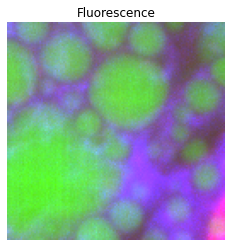

In [4]:
targ = FluorescenceTile.create(os.path.join(path, df.iloc[100].target_fn), STATS)
targ.show();

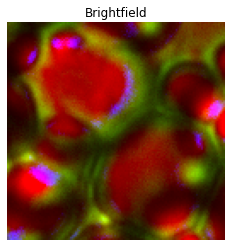

In [5]:
s = BrightfieldTile.create(os.path.join(path, df.iloc[25].fn), STATS)
s.show();

In [6]:
brightfield_paths = [os.path.join(path, fn) for fn in df.fn.values]
fluorescence_paths = [os.path.join(path, fn) for fn in df.target_fn.values]
is_train = [fold != 0 for fold in df.fold.values]
df['is_val'] = ~np.array(is_train)

augmentations = PairAugmentations()

tfm = PairTransform(
    brightfield_paths, 
    fluorescence_paths, 
    stats=STATS,
    augment_func=augmentations,
    augment_samples=is_train
)

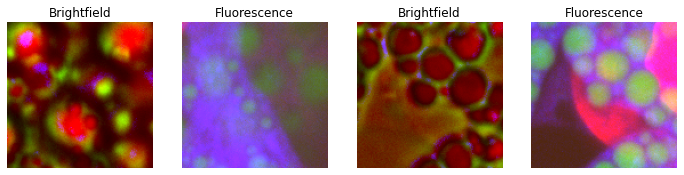

In [7]:
splitter = FuncSplitter(lambda o: df[df.fn == str(o).replace(path,'')].is_val.values[0])
splits = splitter(brightfield_paths)

tls = TfmdLists(range(len(brightfield_paths)), tfm, splits=splits)
dls = tls.dataloaders(bs=bs)
dls.show_batch()

In [8]:
def resnet34_7chan(pretrained=True):
    resnet = models.resnet34(pretrained=pretrained)
    conv1 = nn.Conv2d(7, 64, kernel_size=7, stride=2, padding=3, bias=False)
    if pretrained:
        w = resnet.conv1.weight
        conv1.weight = nn.Parameter(torch.cat((w,
               0.5*(w[:,:1,:,:]+w[:,2:,:,:]),
               0.5*(w[:,:1,:,:]+w[:,2:,:,:]),
               0.5*(w[:,:1,:,:]+w[:,2:,:,:]),
               0.5*(w[:,:1,:,:]+w[:,2:,:,:])
              ),dim=1))
    resnet.conv1 = conv1
    return resnet

def resnet50_7chan(pretrained=True):
    resnet = models.resnet50(pretrained=pretrained)
    conv1 = nn.Conv2d(7, 64, kernel_size=7, stride=2, padding=3, bias=False)
    if pretrained:
        w = resnet.conv1.weight
        conv1.weight = nn.Parameter(torch.cat((w,
               0.5*(w[:,:1,:,:]+w[:,2:,:,:]),
               0.5*(w[:,:1,:,:]+w[:,2:,:,:]),
               0.5*(w[:,:1,:,:]+w[:,2:,:,:]),
               0.5*(w[:,:1,:,:]+w[:,2:,:,:])
              ),dim=1))
    resnet.conv1 = conv1
    return resnet

In [25]:
loss = VGGTrainedPerceptualLoss(pretrained_path='../models/vgg16_siamese.pth')

In [26]:
learn = unet_learner(
    dls, 
    resnet34_7chan, 
    n_out=3, 
    loss_func=loss
)

SuggestedLRs(lr_min=0.0015848932787775993, lr_steep=6.309573450380412e-07)

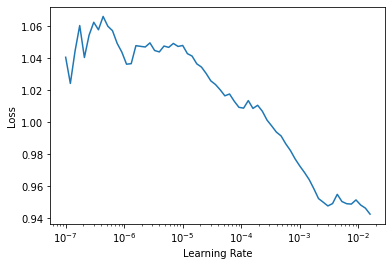

In [27]:
learn.lr_find()

In [28]:
learn.fine_tune(8, base_lr=1e-4, freeze_epochs=2)

epoch,train_loss,valid_loss,time
0,0.880498,0.857591,00:12
1,0.832905,0.820316,00:12


epoch,train_loss,valid_loss,time
0,0.809528,0.801833,00:14
1,0.786673,0.783372,00:14
2,0.778440,0.780255,00:14
3,0.762405,0.762290,00:14
4,0.762970,0.751750,00:14
5,0.758796,0.752468,00:14
6,0.755107,0.747651,00:15
7,0.745215,0.747881,00:14


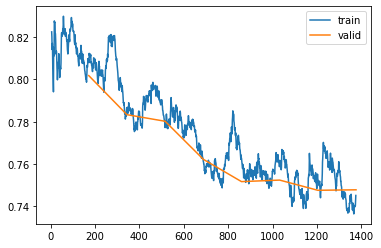

In [29]:
learn.recorder.plot_loss()

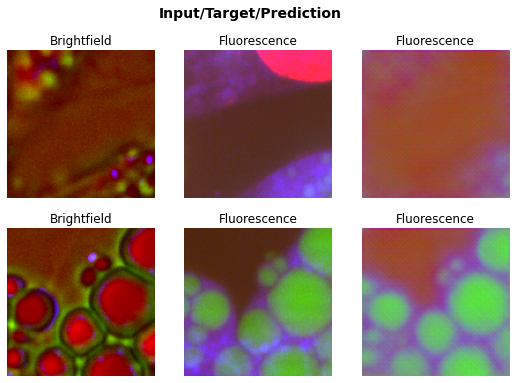

In [30]:
learn.show_results()

In [31]:
learn.fit_flat_cos(20, lr=1e-4)

epoch,train_loss,valid_loss,time
0,0.752796,0.736892,00:13
1,0.740086,0.732309,00:13
2,0.737931,0.727222,00:13
3,0.724946,0.720662,00:13
4,0.710864,0.719270,00:14
5,0.711874,0.713560,00:13
6,0.707433,0.729245,00:13
7,0.700035,0.713718,00:13
8,0.695921,0.710641,00:13
9,0.697900,0.708293,00:13


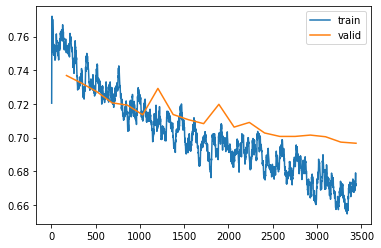

In [32]:
learn.recorder.plot_loss()

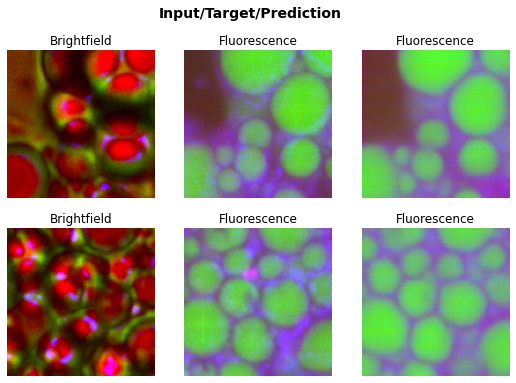

In [33]:
learn.show_results()

In [34]:
learn.fit_flat_cos(20, lr=5e-5)

epoch,train_loss,valid_loss,time
0,0.670505,0.703280,00:13
1,0.662403,0.698287,00:14
2,0.669967,0.704044,00:14
3,0.666866,0.697592,00:14
4,0.660234,0.699201,00:14
5,0.666996,0.699943,00:14
6,0.651704,0.699104,00:14
7,0.654915,0.699023,00:14
8,0.646870,0.700824,00:14
9,0.655568,0.698813,00:13


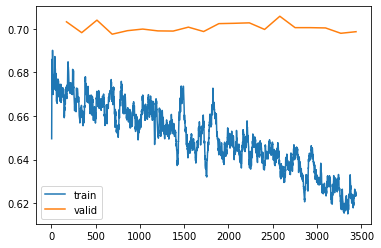

In [35]:
learn.recorder.plot_loss()

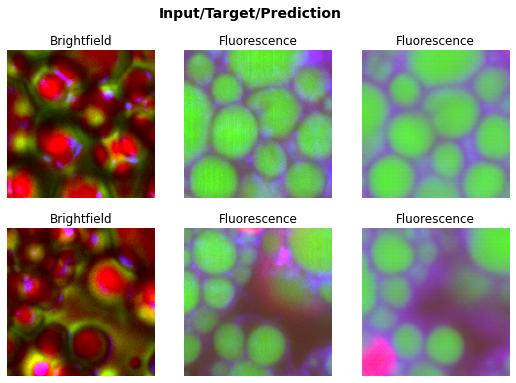

In [36]:
learn.show_results()